In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


if torch.backends.mps.is_available():
  mps_device = torch.device("mps")
  x = torch.ones(1, device=mps_device)
  print (x)
else:
  print ("MPS device not found.")

tensor([1.], device='mps:0')


In [2]:
# read words
words = open("names.txt", "r").read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build vocabulary of characters and mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle words
import random
random.seed(42)
random.shuffle(words)

In [75]:
# build the dataset
block_size = 8

def build_dataset(words, block_size=3):
    X, Y = [], []
    for w in words:
        
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [76]:
# layers

class Linear:
    
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
        self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])
  
  def to(self, dev):
    self.weight = self.weight.to(dev)
    self.bias = self.bias.to(dev) if type(self.bias) == torch.Tensor else None
    
class Residual:
  
  def __init__(self, fan_in, bias=True):
    self.inner = Sequential([
      Linear(fan_in, fan_in, bias=bias),
      Tanh(),
      Linear(fan_in, fan_in, bias=bias),
      Tanh(),
      Linear(fan_in, fan_in, bias=bias),
      Tanh()
    ])
    
  def __call__(self, x):
    self.identity = x
    self.out = self.inner(x) + x
    return self.out
  
  def parameters(self):
    return self.inner.parameters()
  
  def to(self, dev):
    self.inner = self.inner.to(dev)
  
class ResidualSquish:
  
  def __init__(self, fan_in, n_hidden, bias=True):
    self.inner = Sequential([
      Linear(fan_in, n_hidden, bias=bias),
      Tanh(),
      Linear(n_hidden, n_hidden, bias=bias),
      Tanh(),
      Linear(n_hidden, fan_in, bias=bias),
      Tanh(),
    ])
    
  def __call__(self, x):
    self.identity = x
    self.out = self.inner(x) + x
    return self.out
  
  def parameters(self):
    return self.inner.parameters()
  
  def to(self, dev):
    self.inner = self.inner.to(dev)
    
    
class BatchNorm1d:
    
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    # parameters
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    # buffers
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):

    # set dims
    if x.ndim == 2:
      dim = 0
    elif x.ndim == 3:
      dim = (0,1)

    # set batch stats
    if self.training:
      xmean = x.mean(dim, keepdim=True)
      xvar = x.var(dim, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    # forward pass
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    # update
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + \
                            self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + \
                           self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]
  
  def to(self, dev):
    self.eps = self.eps#.to(dev)
    self.momentum = self.momentum#.to(dev)

    # parameters
    self.gamma = self.gamma.to(dev)
    self.beta = self.beta.to(dev)

    # buffers
    self.running_mean = self.running_mean.to(dev)
    self.running_var = self.running_var.to(dev)
    
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []  
  
  def to(self, dev):
    pass
  
class Relu:
  def __call__(self, x):
    self.out = torch.relu(x)
    return self.out
  
  def parameters(self):
    return []
  
  def to(self, dev):
    pass
        
class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
  
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]
  
  def to(self, dev):
    self.weight = self.weight.to(dev)
  
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
  
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []
  
  def to(self, dev):
    pass
  
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
    
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
  
  def to(self, dev):
    for layer in self.layers:
      layer.to(dev)

In [77]:
torch.manual_seed(42)

In [102]:
n_embed = 32
n_hidden = 64

model = Sequential([
  Embedding(vocab_size, n_embed),
  FlattenConsecutive(2),
  Linear(n_embed*2, n_hidden, bias=False), Tanh(),
  Linear(n_hidden, n_hidden // 2, bias=False), Tanh(),
  Linear(n_hidden // 2, n_hidden // 2, bias=False), Tanh(),
  FlattenConsecutive(2),
  Linear(n_hidden, n_hidden // 2, bias=False), Tanh(),
  Linear(n_hidden // 2, n_hidden // 4, bias=False), Tanh(),
  Linear(n_hidden // 4, n_hidden // 4, bias=False), Tanh(),
  FlattenConsecutive(2),
  Linear(n_hidden // 2, n_hidden // 4, bias=False), Tanh(),
  Linear(n_hidden // 4, n_hidden // 4, bias=False), Tanh(),
  Linear(n_hidden // 4, n_hidden // 4, bias=False), Tanh(),
  Linear(n_hidden // 4, vocab_size)
])

# model = Sequential([
#   Embedding(vocab_size, n_embed),
#   FlattenConsecutive(2),
#   ResidualSquish(n_embed*2, n_embed, bias=False),
#   Linear(n_embed*2, n_hidden, bias=False),
#   BatchNorm1d(n_hidden), Tanh(),
#   FlattenConsecutive(2),
#   ResidualSquish(n_hidden*2, n_hidden, bias=False),
#   Linear(n_hidden*2, n_hidden, bias=False),
#   BatchNorm1d(n_hidden), Tanh(),
#   FlattenConsecutive(2),
#   ResidualSquish(n_hidden*2, n_hidden, bias=False),
#   Linear(n_hidden*2, n_hidden, bias=False),
#   BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size)
# ])

# model = Sequential([
#   Embedding(vocab_size, n_embed), 
#   FlattenConsecutive(2), Residual(n_embed*2, bias=False),
#   Residual(n_embed*2, bias=False), ResidualSquish(n_embed*2, n_embed, bias=False),
#   Linear(n_embed * 2, n_hidden, bias=False),
#   BatchNorm1d(n_hidden), Tanh(),
#   FlattenConsecutive(2), Residual(n_hidden*2, bias=False),
#   Residual(n_hidden*2, bias=False), ResidualSquish(n_hidden*2, n_hidden, bias=False),
#   Linear(n_hidden * 2, n_hidden, bias=False),
#   BatchNorm1d(n_hidden), Tanh(),
#   FlattenConsecutive(2), Residual(n_hidden*2, bias=False),
#   Residual(n_hidden*2, bias=False), ResidualSquish(n_hidden*2, n_hidden, bias=False),
#   Linear(n_hidden * 2, n_hidden, bias=False),
#   BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# model = Sequential([
#   Embedding(vocab_size, n_embed), 
#   FlattenConsecutive(2), Residual(n_embed*2, bias=False),
#   Residual(n_embed*2, bias=False), Residual(n_embed*2, bias=False),
#   Linear(n_embed * 2, n_hidden, bias=False),
#   BatchNorm1d(n_hidden), Tanh(),
#   FlattenConsecutive(2), Residual(n_hidden*2, bias=False),
#   Residual(n_hidden*2, bias=False), Residual(n_hidden*2, bias=False),
#   Linear(n_hidden * 2, n_hidden, bias=False),
#   BatchNorm1d(n_hidden), Tanh(),
#   FlattenConsecutive(2), Residual(n_hidden*2, bias=False),
#   Residual(n_hidden*2, bias=False), Residual(n_hidden*2, bias=False),
#   Linear(n_hidden * 2, n_hidden, bias=False),
#   BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

with torch.no_grad():
  model.layers[-1].weight *= 0.1
            
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12331


In [103]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
print(Xb)

torch.Size([4, 8])
tensor([[ 0,  0,  0,  0,  0,  0, 10,  1],
        [ 0,  0,  0,  0,  0,  0,  0, 11],
        [ 0,  0,  0,  0,  0, 10,  1, 14],
        [ 0,  0,  0,  0, 14,  5, 22,  1]])


In [104]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 32)
FlattenConsecutive : (4, 4, 64)
Linear : (4, 4, 64)
Tanh : (4, 4, 64)
Linear : (4, 4, 32)
Tanh : (4, 4, 32)
Linear : (4, 4, 32)
Tanh : (4, 4, 32)
FlattenConsecutive : (4, 2, 64)
Linear : (4, 2, 32)
Tanh : (4, 2, 32)
Linear : (4, 2, 16)
Tanh : (4, 2, 16)
Linear : (4, 2, 16)
Tanh : (4, 2, 16)
FlattenConsecutive : (4, 32)
Linear : (4, 16)
Tanh : (4, 16)
Linear : (4, 16)
Tanh : (4, 16)
Linear : (4, 16)
Tanh : (4, 16)
Linear : (4, 27)


In [105]:
model.layers[1].out.shape

torch.Size([4, 4, 64])

In [106]:
torch.randn(4,4,3)

tensor([[[-0.0902, -0.5047, -2.2373],
         [ 0.6428,  0.0389, -0.7496],
         [ 0.6501,  0.4873, -2.0819],
         [ 0.7848, -1.5781,  0.8422]],

        [[-1.7483, -0.6648, -0.2833],
         [ 0.6204,  1.3559,  0.2789],
         [-1.2089,  0.4569,  0.5639],
         [-0.3513,  0.6155,  0.0904]],

        [[-0.1138,  0.1742,  1.1316],
         [-0.2073, -0.7313,  0.0680],
         [ 0.9588,  1.0857, -0.8533],
         [-0.0732,  0.9075,  0.1247]],

        [[-0.2136,  1.2397, -0.4081],
         [ 1.7050, -0.0529, -0.4899],
         [ 0.5288,  0.3200,  0.6502],
         [ 0.5259, -1.5063, -0.7744]]])

In [107]:
p = model.parameters()
torch.tensor(list(map(lambda e: e.mean(), p)), dtype=float).sum()

tensor(-0.0481, dtype=torch.float64)

In [ ]:
# optimization

# torch.autograd.set_detect_anomaly(True)

max_steps = 20_000
batch_size = 32
lossi = []
vlossi = []
ud = []

# Xtr = Xtr.to('mps')
# Ytr = Ytr.to('mps')
# Xdev = Xdev.to('mps')
# Ydev = Ydev.to('mps')

for i in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) + 0.25*torch.tensor(list(map(lambda e: e.mean(), p)), dtype=float).sum()
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 150_000 else 0.01 # step decay
    for p in parameters:
        p.data += -lr * p.grad

    # validation tracking
#     vx = torch.randint(0, Xdev.shape[0], (batch_size * 2,))
#     Xv, Yv = Xdev[vx], Ydev[vx]
    
#     vlogits = model(Xv)
#     vloss = F.cross_entropy(vlogits, Yv)
    
#     vlossi.append(vloss.log10().item())
    
    # tracking
    if i % 1_000 == 0:
      # validation tracking
      Xv, Yv = Xdev, Ydev

      vlogits = model(Xv)
      vloss = F.cross_entropy(vlogits, Yv)

      vlossi.append(vloss.log10().item())
      
      print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f} | {vloss.item():.4f}")
    
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
#     if i >= 1000:
#         break
    

      0/  20000: 2.8111 | 2.7166
   1000/  20000: 2.2523 | 2.4112
   2000/  20000: 2.6461 | 2.3741
   3000/  20000: 2.2242 | 2.3473
   4000/  20000: 2.4714 | 2.3242


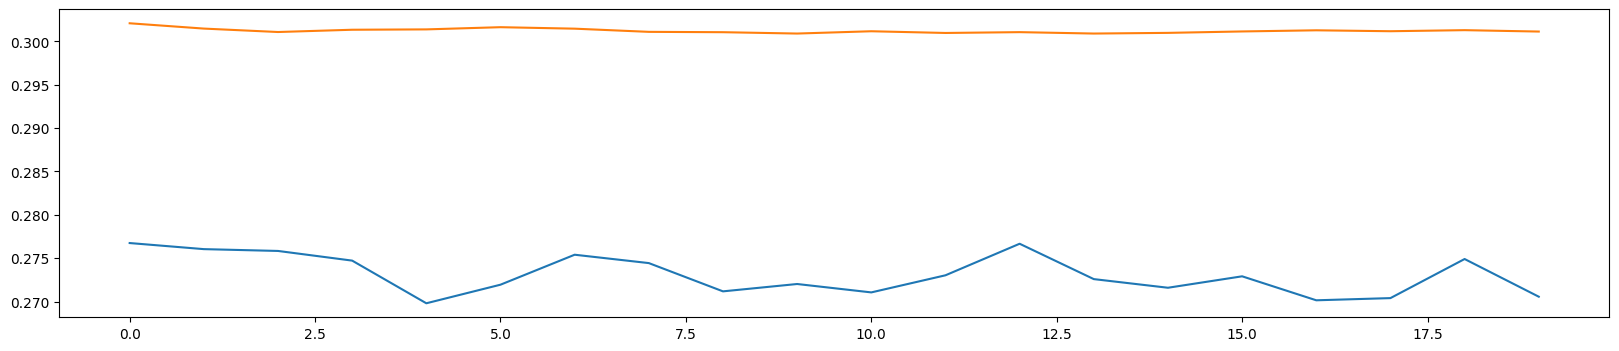

In [97]:
plt.figure(figsize=(20,4))
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))
plt.plot(torch.tensor(vlossi))

In [ ]:
# visualize updates
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param {i}")
plt.plot([0, len(ud)], [-3, -3], "k")
plt.legend(legends)

In [101]:
checkpoint = model

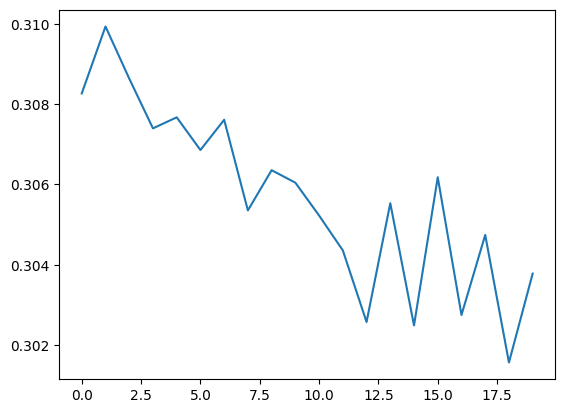

In [345]:


plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [296]:
Xb

tensor([[ 0,  0,  0,  0,  0,  0,  7,  1],
        [ 0,  0,  0,  0,  0,  0,  1,  1],
        [ 0,  0,  0,  0,  0,  0,  0, 11],
        [ 0,  0,  0,  0,  5, 12, 12,  1]])

In [313]:
# eval mode
for layer in model.layers:
  layer.training = False

In [314]:
model

In [366]:
# evaluate loss
@torch.no_grad()
def split_loss(split):
  x, y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
  
split_loss('train')
split_loss('val')

train 1.814495325088501
val 2.009554624557495


In [365]:
# sample from the model

for _ in range(20):
    
  out = []
  context = [0] * block_size
  while True:
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
            
  print(''.join(itos[i] for i in out))

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [363]:
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

RuntimeError: shape '[8, 0, 20]' is invalid for input of size 80

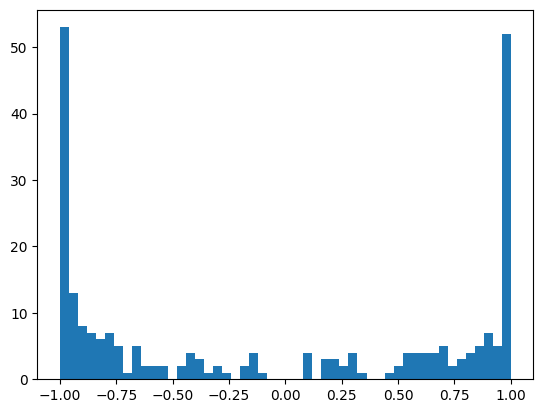

In [544]:
plt.hist(h.view(-1).tolist(), 50);

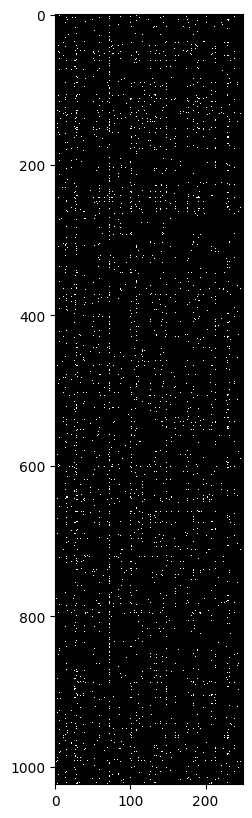

In [537]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

### Cleaned up MLP

In [580]:
# meta parameters

block_size = 3
vocab_size = 27

In [581]:
def build_dataset(words, block_size):
    X, Y = [], []
    for w in words:
        
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

torch.Size([182691, 3]) torch.Size([182691])
torch.Size([22793, 3]) torch.Size([22793])
torch.Size([22662, 3]) torch.Size([22662])


In [590]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        
        # set batch stats
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        # forward pass
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        # update
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + \
                                    self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + \
                                   self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

n_embed = 10
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator = g)
layers = [
    Linear(n_embed * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # lower confidence of final layer
    layers[-1].gamma *= 0.1
    # apply gain to others
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
                    
        

47551


In [595]:
max_steps = 200_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # step decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # tracking
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break
    

      0/ 200000: 3.2667


layer 4 (Tanh      ): mean +0.03, std 0.84, saturated: 37.62%
layer 8 (Tanh      ): mean +0.07, std 0.84, saturated: 44.75%
layer 12 (Tanh      ): mean -0.00, std 0.63, saturated: 13.00%


Text(0.5, 1.0, 'activation distribution')

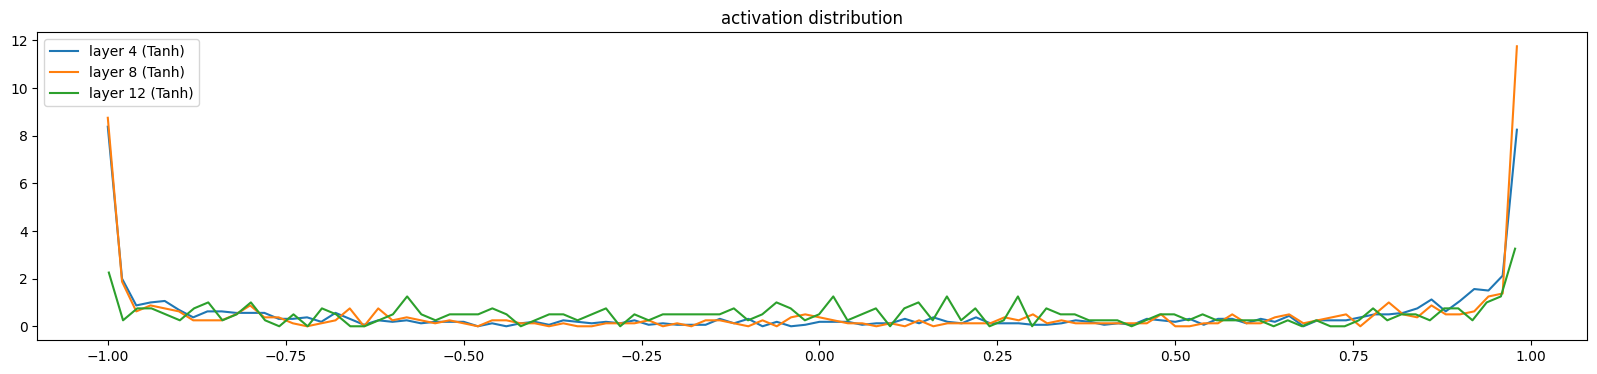

In [177]:
# visualize weight
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(model.layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"layer {i} ({layer.__class__.__name__:10s}): " + \
              f"mean {t.mean():+.2f}, std {t.std():.2f}, " + \
              f"saturated: {(t.abs() > 0.97).float().mean()*100:.2f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distribution")

In [178]:
# visualize grad
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(model.layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"layer {i} ({layer.__class__.__name__:10s}): " + \
              f"mean {t.mean():+f}, std {t.std():e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("gradient distribution")

/var/folders/mr/zywsm0y56k77n0srs2x5lf100000gn/T/ipykernel_92864/3582200667.py:6: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:492.)
  t = layer.out.grad


AttributeError: 'NoneType' object has no attribute 'mean'

<Figure size 2000x400 with 0 Axes>

weight (27, 32) | mean +0.000 | std 5.851e-03 | grad:data ratio 5.940e-03
weight (64, 64) | mean -0.000 | std 9.852e-03 | grad:data ratio 6.543e-02
weight (64, 64) | mean +0.000 | std 8.579e-03 | grad:data ratio 6.195e-02
weight (64, 64) | mean +0.000 | std 8.361e-03 | grad:data ratio 5.880e-02
weight (64, 64) | mean +0.000 | std 7.505e-03 | grad:data ratio 5.489e-02
weight (64, 64) | mean +0.000 | std 7.741e-03 | grad:data ratio 5.436e-02
weight (64, 64) | mean +0.000 | std 6.806e-03 | grad:data ratio 5.020e-02
weight (64, 32) | mean +0.000 | std 1.305e-02 | grad:data ratio 6.499e-02
weight (64, 64) | mean +0.000 | std 1.393e-02 | grad:data ratio 8.462e-02
weight (64, 64) | mean +0.000 | std 1.229e-02 | grad:data ratio 8.373e-02
weight (64, 64) | mean +0.000 | std 1.178e-02 | grad:data ratio 7.624e-02
weight (64, 64) | mean -0.000 | std 8.936e-03 | grad:data ratio 6.231e-02
weight (64, 64) | mean -0.000 | std 1.135e-02 | grad:data ratio 7.417e-02
weight (64, 64) | mean +0.000 | std 8.

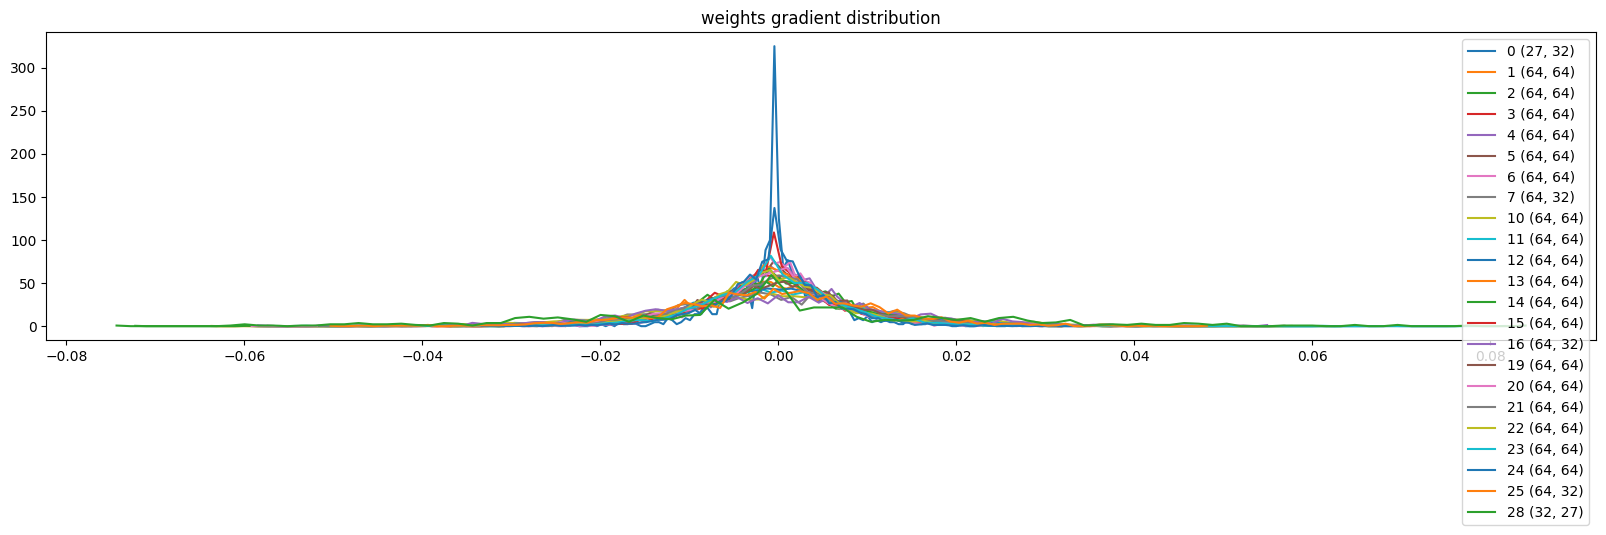

In [347]:
# visualize weights
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(model.parameters()):
    t = p.grad
    if p.ndim == 2:
        print(f"weight {tuple(p.shape)} | mean {t.mean():+.3f} | " + \
              f"std {t.std():.3e} | grad:data ratio {t.std() / p.std():.3e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution");

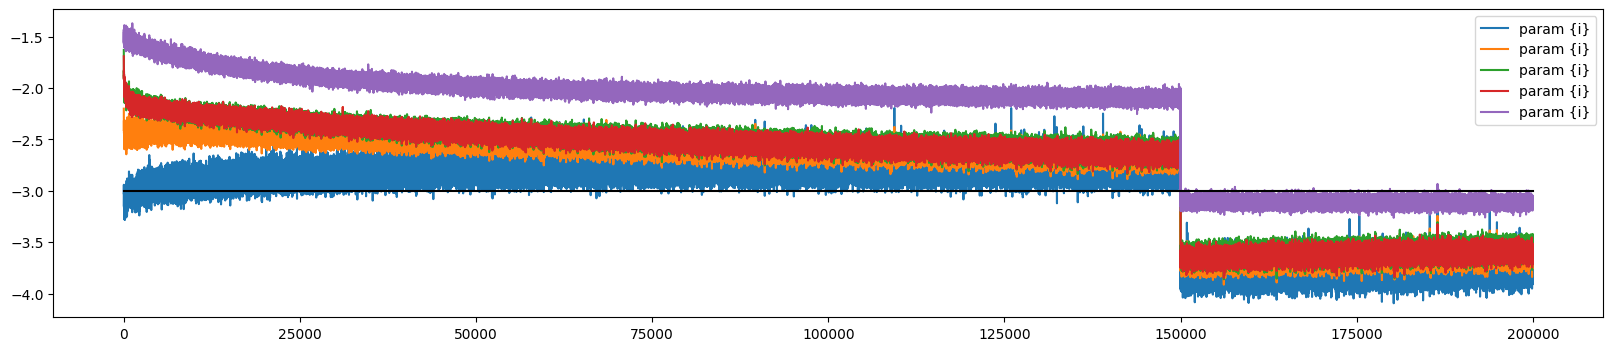

In [180]:
# visualize updates
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param {i}")
plt.plot([0, len(ud)], [-3, -3], "k")
plt.legend(legends)

### Become a Backprop Ninja

In [613]:
# meta parameters

block_size = 3
vocab_size = 27

In [614]:
def build_dataset(words, block_size):
    X, Y = [], []
    for w in words:
        
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22740, 3]) torch.Size([22740])
torch.Size([22826, 3]) torch.Size([22826])


In [ ]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}")

In [621]:
n_embed = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed))
# Layer 1
W1 = torch.randn((n_embed * block_size, n_hidden), generator = g) * (5/3)/((n_embed * block_size)**0.5)
b1 = torch.randn(n_hidden, generator = g) * 0.1

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.1
b2 = torch.randn(vocab_size, generator = g) * 0.1

# BatchNorm
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


4137


In [622]:
batch_size = 32
n = batch_size

# minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [615]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        
        # set batch stats
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        # forward pass
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        # update
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + \
                                    self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + \
                                   self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

n_embed = 10
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator = g)
layers = [
    Linear(n_embed * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # lower confidence of final layer
    layers[-1].gamma *= 0.1
    # apply gain to others
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
                    
        

47551


In [616]:
max_steps = 200_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # step decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # tracking
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break
    

      0/ 200000: 3.2899


layer 2 (Tanh      ): mean -0.00, std 0.63, saturated: 2.88%
layer 5 (Tanh      ): mean -0.00, std 0.64, saturated: 2.50%
layer 8 (Tanh      ): mean -0.01, std 0.64, saturated: 2.47%
layer 11 (Tanh      ): mean -0.00, std 0.64, saturated: 2.22%
layer 14 (Tanh      ): mean -0.01, std 0.64, saturated: 2.41%


Text(0.5, 1.0, 'activation distribution')

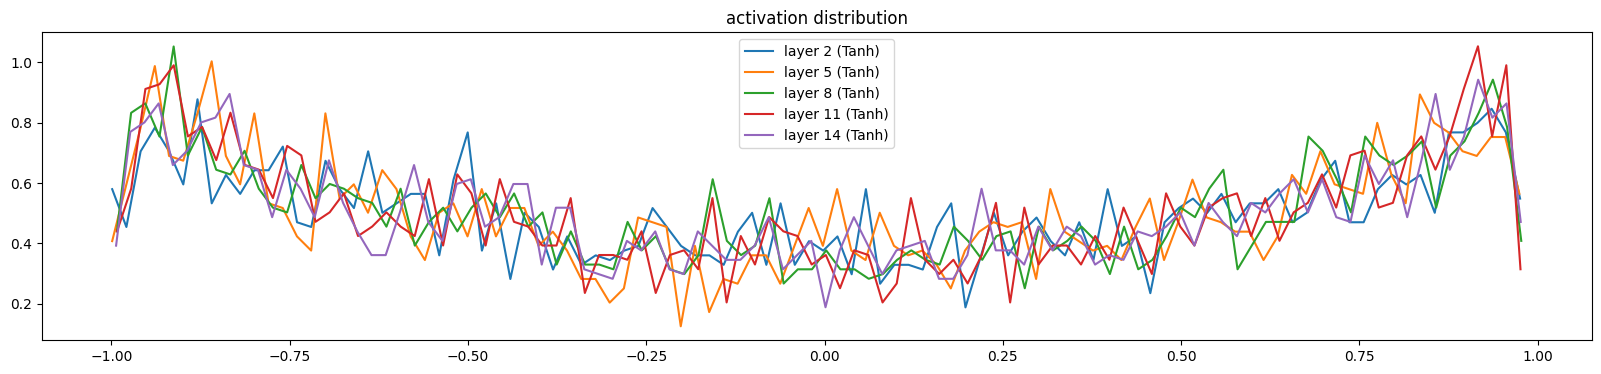

In [617]:
# visualize weight
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"layer {i} ({layer.__class__.__name__:10s}): " + \
              f"mean {t.mean():+.2f}, std {t.std():.2f}, " + \
              f"saturated: {(t.abs() > 0.97).float().mean()*100:.2f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distribution")

layer 2 (Tanh      ): mean +0.000000, std 3.828418e-03
layer 5 (Tanh      ): mean -0.000000, std 3.106622e-03
layer 8 (Tanh      ): mean -0.000000, std 2.814896e-03
layer 11 (Tanh      ): mean +0.000000, std 2.566039e-03
layer 14 (Tanh      ): mean +0.000000, std 2.349659e-03


Text(0.5, 1.0, 'gradient distribution')

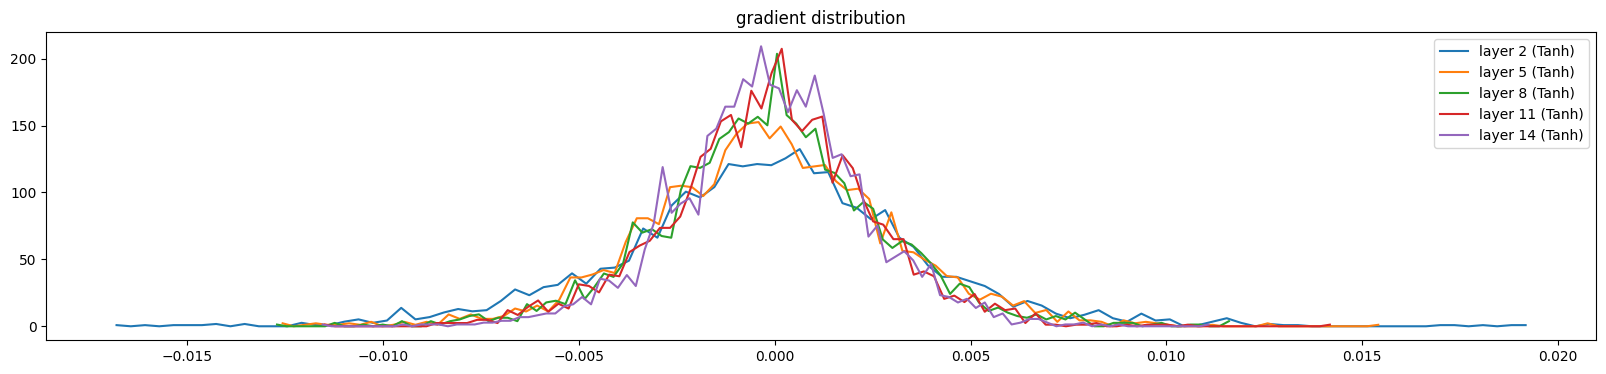

In [618]:
# visualize grad
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"layer {i} ({layer.__class__.__name__:10s}): " + \
              f"mean {t.mean():+f}, std {t.std():e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("gradient distribution")

weight (27, 10) | mean -0.000 | std 1.292e-02 | grad:data ratio 1.290e-02
weight (30, 100) | mean -0.000 | std 1.050e-02 | grad:data ratio 3.358e-02
weight (100, 100) | mean +0.000 | std 8.071e-03 | grad:data ratio 4.827e-02
weight (100, 100) | mean +0.000 | std 7.005e-03 | grad:data ratio 4.153e-02
weight (100, 100) | mean -0.000 | std 6.416e-03 | grad:data ratio 3.822e-02
weight (100, 100) | mean -0.000 | std 5.288e-03 | grad:data ratio 3.149e-02
weight (100, 27) | mean +0.000 | std 9.934e-03 | grad:data ratio 5.957e-02


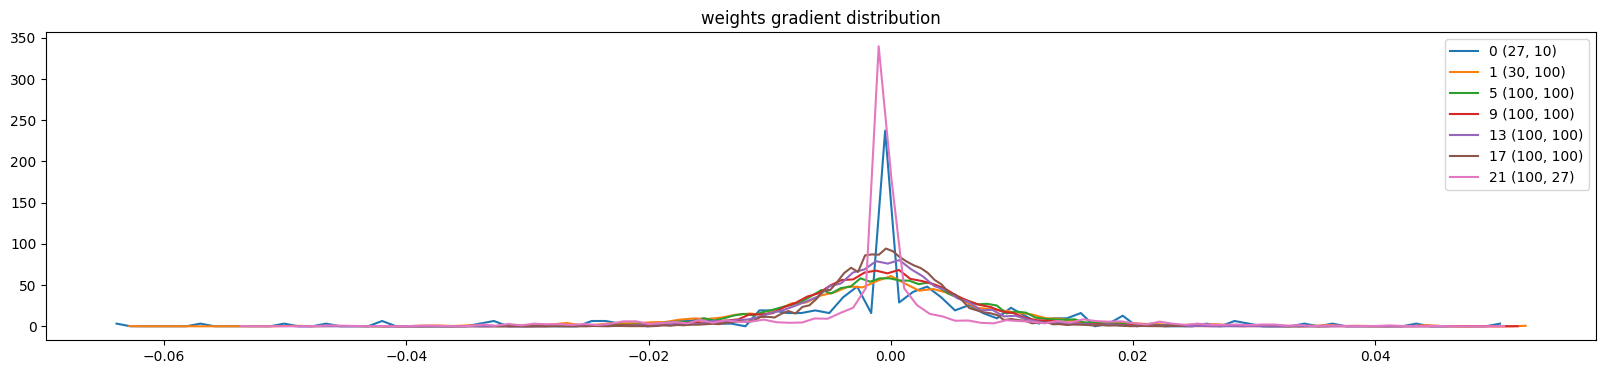

In [619]:
# visualize weights
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f"weight {tuple(p.shape)} | mean {t.mean():+.3f} | " + \
              f"std {t.std():.3e} | grad:data ratio {t.std() / p.std():.3e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution");

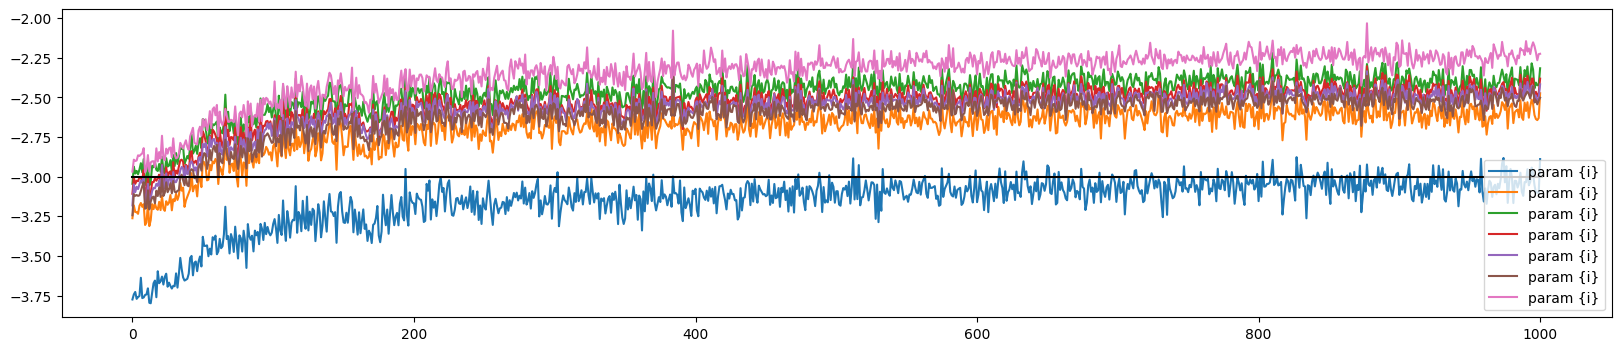

In [620]:
# visualize updates
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param {i}")
plt.plot([0, len(ud)], [-3, -3], "k")
plt.legend(legends)